BE/Bi 103, Fall 2014: Homework 7
================================
Due 1pm, Monday, December 8
---------------------------

*This document was generated from a Jupyter notebook.  You can download the notebook [here](hw7.ipynb).*


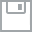
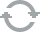
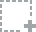
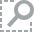
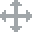
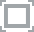
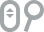
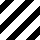
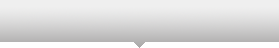
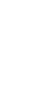
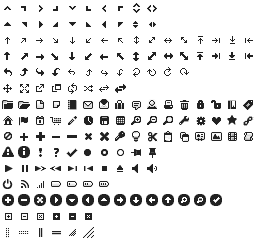
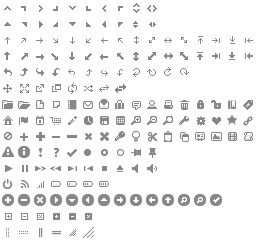
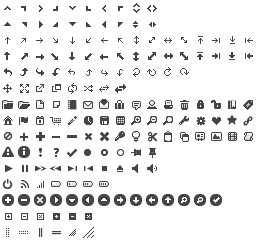
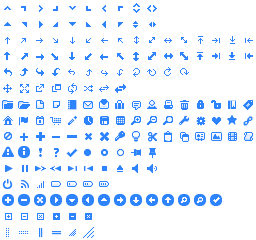
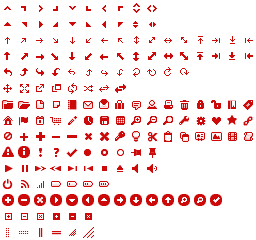
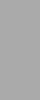
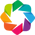
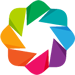

In [37]:
# As usual, import modules
from __future__ import division, absolute_import, print_function

import os
    
import numpy as np
import scipy.optimize
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import scipy.ndimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation

# Utilities from JB
import jb_utils as jb
import bebi103

# Numdifftools for Hessian calculations
import numdifftools as ndt

# Necessary to display plots in this IPython notebook
%matplotlib inline

# High res PNGs for images
%config InlineBackend.figure_formats = {'png', 'retina'}

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.models
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

### Problem 7.1 (Caulobacter growth, 60 pts)

In this problem, we will study the growth and division of *Caulobacter crescentus* over time.  The lab of [Norbert Scherer](http://schererlab.uchicago.edu) at the University of Chicago acquired these data and recently published the work in PNAS, which you can download [here](http://bebi103.caltech.edu/2014/protected/papers/iyer-biswas_2014.pdf).

The clever experimental set-up allows imaging of single dividing cells in conditions that are identical through time.  This is accomplished by taking advantage of a unique morphological feature of *Caulobacter*.  The mother cell is adherent to the a surface through its stalk.  Upon division, one of the daughter cells does not have a stalk and is mobile.  The system is part of a microfluidic device that gives a constant flow.  So, every time a mother cell divides, the un-stalked daughter cell gets washed away.  In such a way, the dividing cells are never in a crowded environment and the buffer is always fresh.  This also allows for easier segmentation.

The data were sent to you via Dropbox.  They were kindly provided by Charlie Wright in the Scherer lab.  The frame rate is 1 frame per minute.  The interpixel spacing is 0.052 µm.  All images were acquired at 24 $^\circ$C.

As with any of the problems in this class, you are encouraged to explore the data beyond what is asked for specifically in the problems statements.  The paper is also a very interesting read.

**a)** The directory `sequential_full_field` contains 10 sequential frames of a full field of bacteria in the microfluidic device.  From these frames, choose which bacteria would be good to use to gather long time course imaging.  I.e., choose those that you think will give minimal errors in segmentation.  Give your reasoning, including images demonstrating segmentation.

**b)** The files `bacterium_1.tif` and `bacterium_2.tif` are TIFF stacks of time courses for specific cells in from the full field images.  From these time courses, compute the time scale of division of the cells.  In other words, compute the time between divisions for each division for each cell and plot the results.  Comment on any interesting aspects of these data.

**c)** In their paper, the authors argue that the growth rate of the cell is exponential.  I.e.,

\begin{align}
a(t) = a_0 \mathrm{e}^{\kappa t},
\end{align}

where $a(t)$ is the area of the cell in the image as a function of time and $a_0$ is the area of the cell right after a division has been completed, which we mark as $t = 0$.

As an alternative model, the authors consider a linear growth model, in which

\begin{align}
a(t) = a_0 + b t.
\end{align}

An exponential curve is approximately linear (with $b = a_0\kappa$) for short time scales.  So, it is often difficult to distinguish between a linear and an exponential growth rate.  Use the model selection methods we learned in class to assess the relative probabilites that the growth rate is exponential versus linear.

### Problem 7.1: Solution
**a)** We will begin by loading one of the images and looking at it.

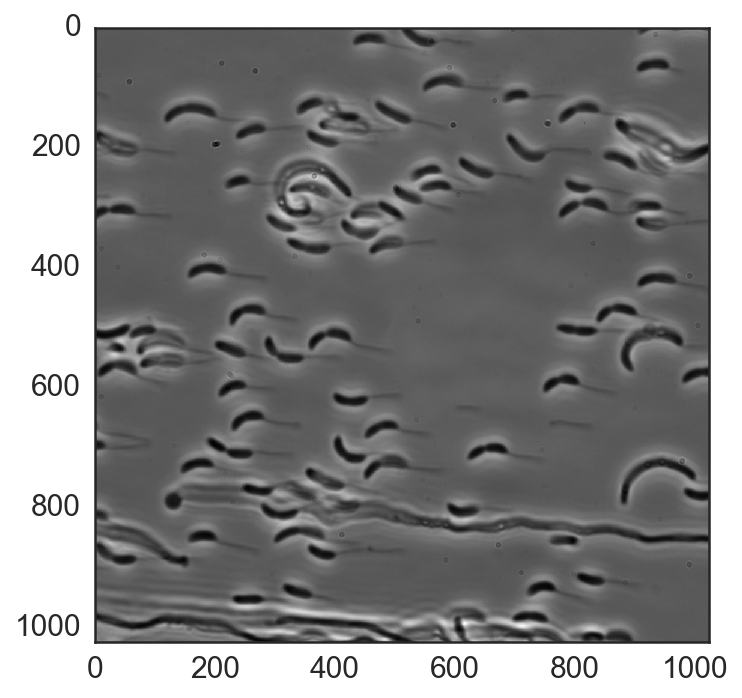

In [2]:
# Load image
data_dir = '../data/iyer-biswas_et_al/hw8_iyer-biswas_et_al'
fname = os.path.join(data_dir, 'sequential_full_field/phase03000.tif')
im = skimage.io.imread(fname)

# Display image
with sns.axes_style('white'):
    plt.imshow(im, cmap=plt.cm.gray)

The best bacteria to segment are those that do not have many neighbors and do not have artifacts around them. This allows us to use simple thresholding for segmentation. Let's try a simple global threshold.

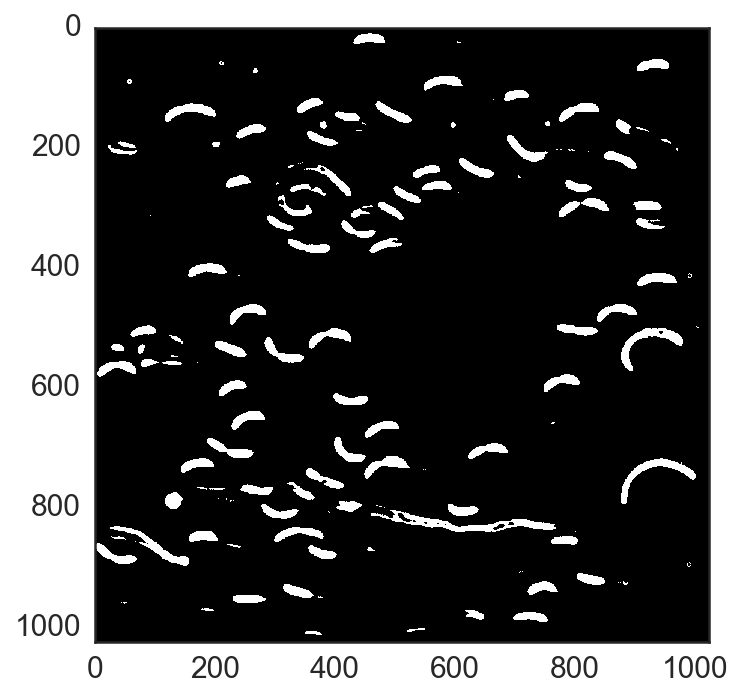

In [3]:
thresh = skimage.filters.threshold_isodata(im)
im_bw = im < thresh
im_bw = skimage.segmentation.clear_border(im_bw)
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

I then took this image and used `plt.ginput()` to click on pixels within good candidate bacteria.

In [4]:
# Indices in good bacteria
good_inds = np.array([(180.83333333333343, 138.16666666666674),
                      (791.5, 588.83333333333337),
                      (674.16666666666674, 703.5),
                      (428.83333333333343, 626.16666666666674),
                      (199.50000000000006, 404.83333333333337)]).astype(int)

Now, I'll label the image and compute region props, keeping only regions that contain the pixels I clicked.

In [5]:
# Label binary image
im_labeled, n_labels = skimage.measure.label(
                    im_bw, background=-1, return_num=True)

# Compute region props
im_props = skimage.measure.regionprops(im_labeled)

# Find regions to keep
for prop in im_props:
    keep = False
    for ind in good_inds:
        if (prop.bbox[0] < ind[1] < prop.bbox[2]) and \
                      (prop.bbox[1] < ind[0] < prop.bbox[3]):
            keep = True
    if not keep:
        im_bw[im_labeled==prop.label] = 0

Now we can overlay the ones we picked.

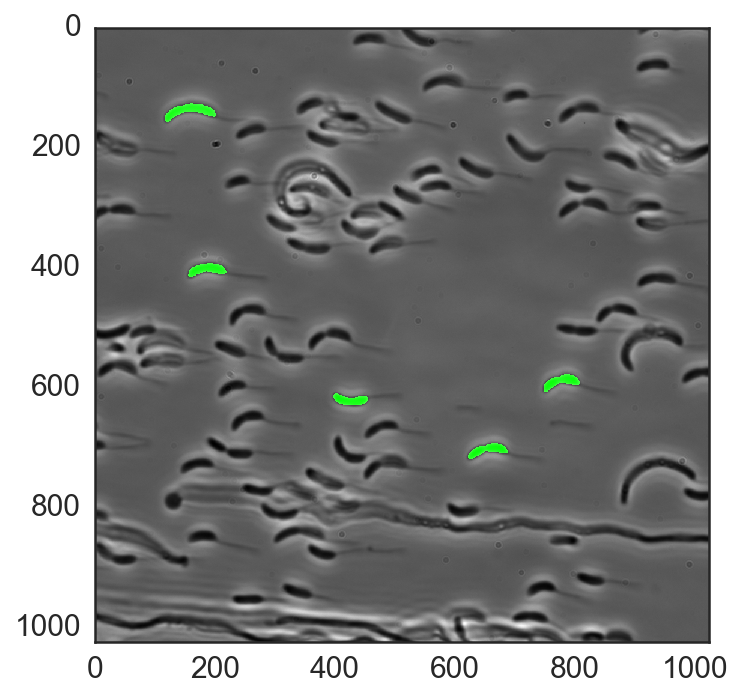

In [6]:
# Convert phase image to float RGB
im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

# Make the green channel 1 wherever we have a bacterium
im_g = np.copy(im_float)
im_g[im_bw] = 1

# Build RGB image
im_rgb = np.dstack((im_float, im_g, im_float))

# Display image
with sns.axes_style('white'):
    plt.imshow(im_rgb)

These are the bacteria that are nicely separated and easily segmented.

**b)** Our strategy to find division events is this:

1. Use simple thresholding to segment the image into bacteria and not bacteria.
2. Clear the borders for bacteria that are not of central interest.
3. Label the image and compute region props.
4. Take the area of the largest object as the area of the bacterium of interest.  These constitute the time series data of area vs. time.
5. Delete areas that are obvious segementation areas where the area is unreasonably large or small.  In this case, we take the lower bound on bacterial size to be 1 µm and the upper bound to be 3.5 µm.
6. Perform a median filter on the remaining area vs. time data.  This eliminates one-off outliers.
7. Find the time points where the median filtered trace has a down-crossing of a threshold.  This threshold is larger than the size of the mother bacterium, in our case, 2 µm.
8. Only downcrossings followed by ten minutes of growth are allowed.  This is a further check to make sure an outlier did not affect the division point.

We start by writing a function to compute the area of the bacteria in the image using thresholding.

In [7]:
def area_thresh(im, interpixel_distance):
    """
    Threshold an image and return the area of the largest object.
    """
    # Threshold image
    im_bw = im < skimage.filters.threshold_otsu(im)
    
    # Clear borders
    im_bw = skimage.segmentation.clear_border(im_bw)
    
    # Label binary image
    im_labeled = skimage.measure.label(im_bw, background=0, return_num=False)
    
    # Find areas of all objects
    im_props = skimage.measure.regionprops(im_labeled + 1)

    # Find largest area
    max_area = 0
    for prop in im_props:
        if prop.area > max_area:
            max_area = prop.area

    return max_area * interpixel_distance**2

We'll now write a function to generate the area vs. time curve as well as the indices where division occurs.

In [8]:
def areas_divisions(t, ic, interpixel_distance, div_thresh, n_below, abs_thresh,
                    median_kernel_size):
    """
    Compute areas of mother bacterium over time
    """
    # Compute the bacterial area for each image
    areas = np.empty(len(ic))
    for i, im in enumerate(ic):
        areas[i] = area_thresh(im, interpixel_distance)
        
    # Determine which points are good
    good_inds = (areas > abs_thresh[0]) & (areas < abs_thresh[1])
    
    # Slice out good data points
    t = t[good_inds]
    areas = areas[good_inds]

    # Perform median filter to eliminate outliers
    areas_filt = scipy.signal.medfilt(areas, kernel_size=median_kernel_size)

    # Get downcrossings
    down_inds = np.where((areas_filt[:-1] > div_thresh) 
                        & (areas_filt[1:] < div_thresh))[0] + 1

    # Filter out spurious downcrossings
    div_inds = [i for i in down_inds 
                        if np.all(areas_filt[i:i+n_below] < div_thresh)]
    
    return t, areas, div_inds

Now we can proceed with our analysis for the first bacterium.  We will use a kernel size of 9 time points for our median kernel.

In [9]:
# Images and metadata
data_dir = '../data/iyer-biswas_et_al/hw8_iyer-biswas_et_al'
fname = os.path.join(data_dir, 'bacterium_1.tif')
interpixel_distance = 0.052  # µm
dt = 1 # minutes

# Threshold for division
div_thresh = 2  # µm^2

# Absolute thresholds for big and small cells
abs_thresh = (1, 3.5) # µm^2

# Number of time points below threshold to be considered divided
n_below = 10

# Size of median filter kernel
median_kernel_size = 9

# Load images using skimage.io's ImageCollection class
ic = skimage.io.ImageCollection(fname)[0]

# Determine time points
t_1 = np.arange(len(ic)) / dt

# Get area/time curve with division points
t_1, areas_1, div_inds_1 = areas_divisions(
        t_1, ic, interpixel_distance, div_thresh, n_below, abs_thresh, 
        median_kernel_size)

Now we can plot the cell areas and division events.  Note that even though we used the median filtered time series to find division events, we plot the unfiltered areas.  We will use the new plotting package [Bokeh](http://bokeh.pydata.org) to enable interactive viewing of the plot.

In [10]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=250)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time(s)'
p.yaxis.axis_label = 'cell area (sq µm)'

# Specify the glyphs
p.circle(t_1, areas_1, size=3)
for di in div_inds_1:
    p.ray(x=t_1[di], y=0, length=0, angle=90, angle_units='deg',
          color='tomato', line_width=2)
    p.ray(x=t_1[di], y=0, length=0, angle=-90, angle_units='deg',
          color='tomato', line_width=2)

bokeh.io.show(p)

Our analysis looks pretty good.  Even though we had some outliers, we still got the division points right.  Note that in come cases, the cell area goes down before the precipitous drop.  This could be due to a cell being almost pinched off and coming in and out of the focal plane, leading to errors in segmentation.

We can repeat the analysis for the other bacterium.

In [11]:
# Images and metadata
fname = os.path.join(data_dir, 'bacterium_2.tif')

# Load images
ic = skimage.io.ImageCollection(fname)[0]

# Determine time points
t_2 = np.arange(len(ic)) / dt

# Do the calculation
t_2, areas_2, div_inds_2 = areas_divisions(
        t_2, ic, interpixel_distance, div_thresh, n_below, abs_thresh, 
        median_kernel_size)

We'll plot the time trace for this one as well.

In [12]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=250)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time(s)'
p.yaxis.axis_label = 'cell area (sq µm)'

# Specify the glyphs
p.circle(t_2, areas_2, size=3)
for di in div_inds_2:
    p.ray(x=t_2[di], y=0, length=0, angle=90, angle_units='deg',
          color='tomato', line_width=2)
    p.ray(x=t_2[di], y=0, length=0, angle=-90, angle_units='deg',
          color='tomato', line_width=2)

bokeh.io.show(p)

It is hard to see without zooming, but you can scroll around the plot and see that we identified all of the division points.

Now, let's look at the distributions of division times for each bacterium.

/Users/Justin/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


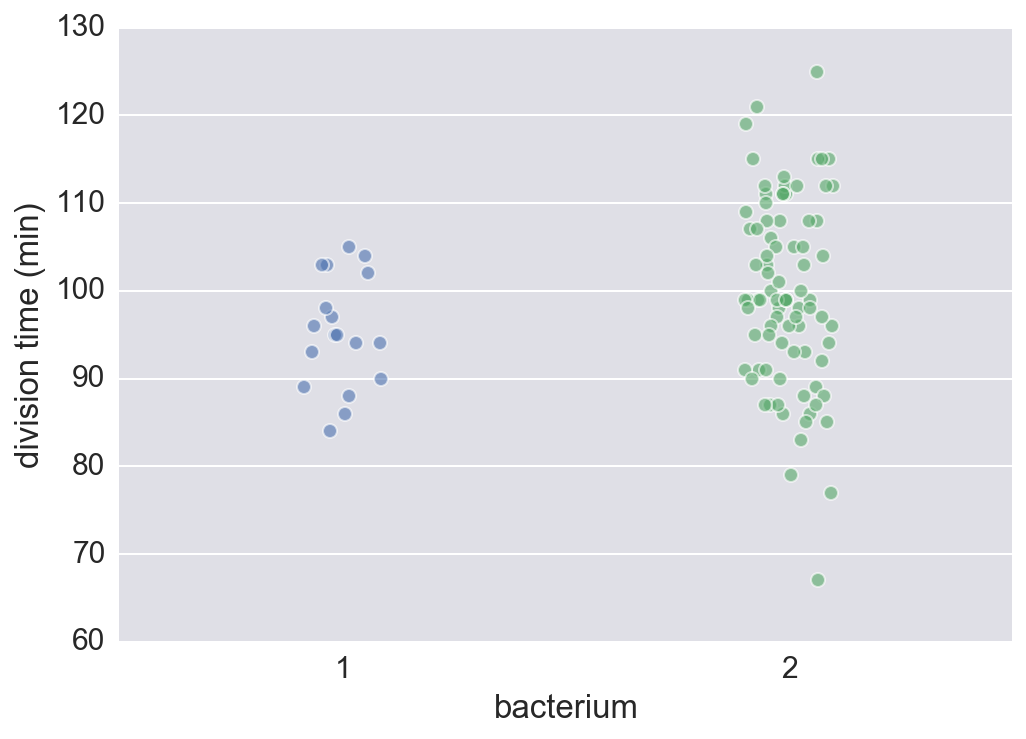

In [13]:
# Set up DataFrame with results
df = pd.DataFrame(columns=['bacterium', 'division time (min)'])
div_times_1 = np.diff(div_inds_1) * dt
div_times_2 = np.diff(div_inds_2) * dt
df['bacterium'] = np.concatenate((np.ones_like(div_times_1), 
                                  np.ones_like(div_times_2) * 2))
df['division time (min)'] = np.concatenate((div_times_1, div_times_2))

sns.stripplot(x='bacterium', y='division time (min)', data=df, jitter=True, 
              alpha=0.6)

The division times between the two seem to be similarly distributed, perhaps with bacterium 2 being more broadly distributed.  We have many more samples for bacterium 2, so we can say more about its distribution.  In particular, we can compute a kernel density estimation and plot the result.


Division time = 99.7 ± 10.6 min



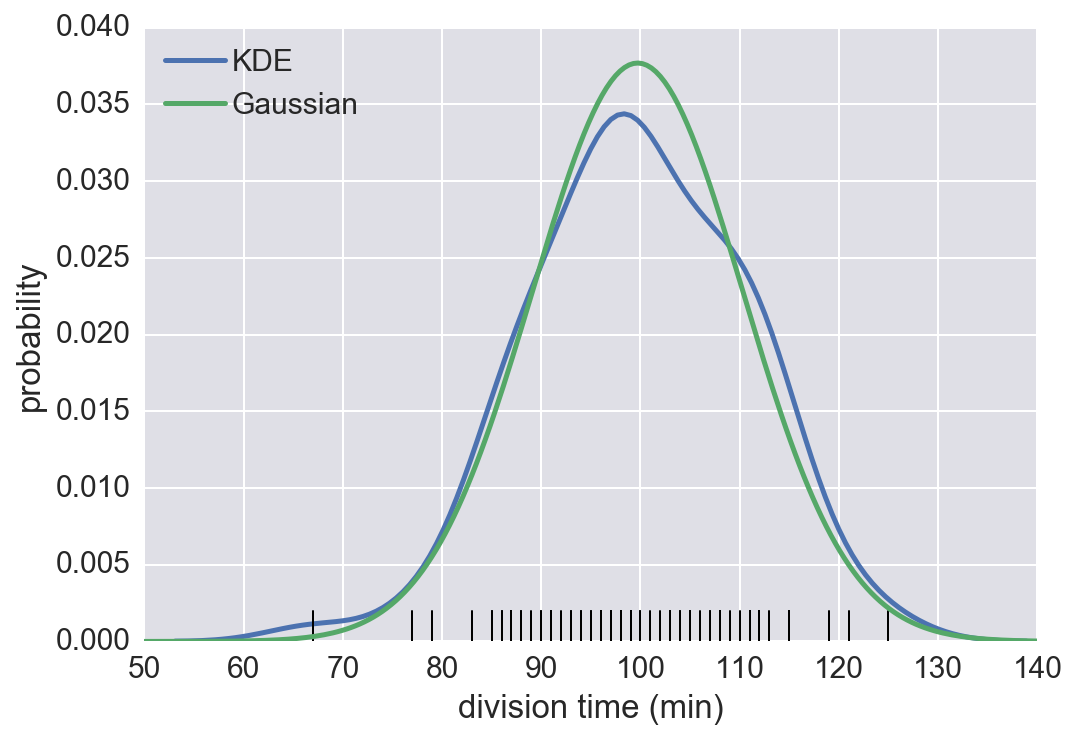

In [14]:
# Make KDE plot
_ = sns.kdeplot(div_times_2, kernel='gau', bw='Scott', label='KDE')
_ = sns.rugplot(div_times_2)

# Make plot of Gaussian with same mean and variance
t_plot = np.linspace(50, 140, 200)
p_gauss = st.norm.pdf(t_plot, div_times_2.mean(), div_times_2.std())
plt.plot(t_plot, p_gauss, label='Gaussian')

# Clean up
plt.xlabel('division time (min)')
plt.ylabel('probability')
plt.legend(loc='upper left')

# Print mean and standard deviation
print("""
Division time = {0:.1f} ± {1:.1f} min
""".format(div_times_2.mean(), div_times_2.std()))

So, the division times are approximately Gaussian distributed with a mean of about 100 minutes and a standard deviation of about 10 minutes.

**c)**  For ease of language, we will use the term "growth event" to describe the growth curve beginning from the completion of a cell division and ending at the subsequent cell division.  

We could take two different approaches to this part of the problem.  First, we could assume each growth event is independent of all others.  So, division event $i$ has slope and intercept $b_i$ and $a_i$, respectively, in the linear model for growth, and these $b_i$ and $a_i$ are independent of all others.  For the exponential growth model, the parameters are $\kappa_i$ and $a_i$.  As another extreme, we could assume that all growth events have the same growth rate.  That is, each growth event has parameters $b$ and $a_i$ under the linear model, and $\kappa$ and $a_i$ for the exponential model.

An alternative to these two extreme models is a [hierarchical model](http://bebi103.caltech.edu/2015/lecture_notes/l08_hierarchical_models.pdf), which is covered in the [2015 solution to this problem](http://bebi103.caltech.edu/2015/protected/hw_solutions/hw8_solution.html#Problem-8.1:-Solution).  I prefer this method, but for this problem, we will take the first approach, in which each growth event is independent of all others.

We will assume that the cell areas are Cauchy distributed about the theoretical growth curve with unknown variance $\sigma$.  We choose the Cauchy distribution because we know there are outliers due to segmentation issues and we do not want them to contribute disproportionately to the likelihood.  The cell area for data point $j$ of growth event $i$ is $A_{ij}$ at time $t_{ij}$.  We define the residual $r_{ij}$ as the difference between the theoretical model and the measured area, $A_{ij}$.  The likelihood for each model is then

\begin{align}
P(D\mid \text{params}, \sigma, I) = \prod_i
\prod_j \left[\pi\beta\left(1+\left(\frac{r_{ij}}{\beta}\right)^2\right)\right]^{-1}.
\end{align}

For the linear growth model ($M_1$), 

\begin{align}
r_{ij} = A_{ij} - a_i - b_i t_{ij}.
\end{align}


For the exponential growth model ($M_2$),

\begin{align}
r_{ij} = A_{ij} - a_i \mathrm{e}^{\kappa_i t_{ij}}.
\end{align}

The properly normalized prior for the linear model is

\begin{align}
P(\mathbf{a}, \mathbf{b}, \beta \mid M_1, I) = \left[(a_\mathrm{max} - a_\mathrm{min})^m (b_\mathrm{max} - b_\mathrm{min})^m\,\beta \ln(\beta_\mathrm{max} / \beta_\mathrm{min})\right]^{-1}
\end{align}

where $m$ is the number of growth events and the max and min subscripts denote bounds on the respective parameters.  For the exponential model, the prior is

\begin{align}
P(\mathbf{a}, \boldsymbol{\kappa}, \sigma \mid M_1, I) = \left[(a_\mathrm{max} - a_\mathrm{min})^m (\kappa_\mathrm{max} - \kappa_\mathrm{min})^m\,\beta \ln(\beta_\mathrm{max} / \beta_\mathrm{min})\right]^{-1}.
\end{align}

In both cases, we have assumed uniform priors on the theoretical model parameters an a Jeffreys prior for $\beta$.

The log posterior is

\begin{align}
\ln P(\mathbf{a}, \mathbf{b}, \beta \mid D, M_1, I) &= \text{constant}
- (N+1)\ln \beta
- \sum_i\sum_j \ln \left[1+\left(\frac{r_{ij}}{\beta}\right)^2\right],
\end{align}

where $N$ is the total number of areas we measured.  To find the most probable parameters, we must optimize this function.  It is a large optimization problem, so we will take the following strategy.

1. Choose a reasonable value for $\beta$.
2. For this value of $\beta$, find the $a_i$ and $b_i$ (or $a_i$ and $\kappa_i$ for the exponential model) that maximize the log posterior.  We can do this for each curve individually.
3. Adjust $\beta$ such that we minimize the log posterior overall.

In practice, then, this becomes a 1-D optimization problem over the parameter $\beta$.

To keep things organized, we will order the parameters as follows for the linear model (with $b_i$ replaced by $\kappa_i$ for the exponential model).

\begin{align}
\mathbf{p} = (a_1, b_1, a_2, b_2, ..., a_m, b_m, \beta).
\end{align}

This is useful because, with the exception of the last row/column, the Hessian of the log posterior is block diagonal.  Instead of computing the entire Hessian, we can only numerically compute the nonzero entries.

With these in hand, we can write the functions we need for log likelihoods and log priors.  The first step, though, is to make the data easier to access.  We want individual time points (always starting at zero at the division event) for each growth curve between divisions.  We will make a list of `DataFrame`s that have these data.

In [15]:
def make_dfs(t, areas, div_inds):
    """
    Create a list of DataFrames containing time/area data between successive
    division event.
    """
    # First division (ignore first time point because it's right before division
    data = np.array([t[1:div_inds[0]] - t[1], areas[1:div_inds[0]]]).T
    df_list = [pd.DataFrame(columns=['t', 'area'], data=data)]

    # Add growth curves for subsequent divisions
    for i, ind in enumerate(div_inds[:-1]):
        data = np.array([t[ind:div_inds[i+1]-1] - t[ind],
                         areas[ind:div_inds[i+1]-1]]).T
        df_list.append(pd.DataFrame(columns=['t', 'area'], data=data))
        
    return df_list

# Make the DataFrames
df_list = make_dfs(t_1, areas_1, div_inds_1) + make_dfs(t_2, areas_2, div_inds_2)

Now we can code up likelihoods and priors.  This is a task easier said than done.  We break this task up into small bits.  First, we need a function to unpack the parameters into $a$'s, $b$'s (or $\kappa$'s), and $\beta$.

In [16]:
def unpack_params(p):
    """
    Unpack the parameters from independent curve fits.
    """
    return p[:-1:2], p[1:-1:2], p[-1]

Next, we will write up a function for the residuals.  We do not want to have to continuously slice `DataFrame`s, so we will only slice it at the beginning of our calculation and use NumPy arrays for the lower level functions, like this one.

In [17]:
def resid(a, bk, t, area, model):
    """
    Residuals for curve fit.
    """
    if model == 'linear':
        return area - a - bk * t
    elif model == 'exponential':
        return area - a * np.exp(bk * t)

Next, we will write the log likelihood for a single growth curve.  Actually, we want the negative log likelihood, since this is what we will use to find $a_i$ and $b_i$ for growth curve $i$ for a given $\beta$.

In [18]:
def neg_log_like_single_curve(a_bk, beta, t, area, model):
    """
    Negative log likelihood for a single growth event
    """
    a, bk = a_bk
    return np.log(1 + (resid(a, bk, t, area, model) / beta)**2).sum() \
                + len(t) * np.log(np.pi * beta)

Now, we can write a function to fit a single growth curve for a given $\beta$ using the negative log likelihood as the objective function.  We usual, we'll use Powell's method.

In [19]:
def fit_single_curve(beta, df, model):
    """
    Find the most probable a and bk for a single growth curve.
    """
    # Generate initial guess based on eyeballed estimates.
    if model == 'linear':
        a_bk0 = np.array([1.3, 0.01])
    elif model == 'exponential':
        a_bk0 = np.array([1.3, 0.006])
        
    # Perform optimization
    res = scipy.optimize.minimize(neg_log_like_single_curve, a_bk0,
                                  args=(beta, df.t.values, df.area.values, model),
                                  method='powell')
    return res.x

Now, of course, we need to write a function to fit all of the curves, one-by-one.  This function returns the optimal parameter array, including the $\beta$ we used as input.

In [20]:
def fit_all_curves(beta, list_of_dfs, model):
    """
    Fit all curves for a given value of beta and return parameter
    array p.
    """
    p = np.array([fit_single_curve(beta, df, model) for df in list_of_dfs])
    return np.append(p.flatten(), beta)

Of course, we will need to compute the posterior for the entire analysis problem so we can find the $\beta$ that minimizes it.

In [25]:
def log_likelihood(p, list_of_dfs, model):
    """
    Log likelihood for independent growth events.
    """
    # Unpack parameters
    a, bk, beta = unpack_params(p)
    
    log_like = 0.0
    for i, df in enumerate(df_list):
        log_like -= neg_log_like_single_curve((a[i], bk[i]), beta, 
                                              df.t.values, df.area.values, model)
        
    return log_like


def log_posterior(p, list_of_dfs, model):
    """
    Unnormalized log posterior.
    """
    return -np.log(p[-1]) + log_likelihood(p, list_of_dfs, model)

Now, we need to write an objective function for finding the most probable $\beta$.  Remember, the idea is to find the optimal $a_i$ and $b_i$ for a given $\beta$, compute the log posterior, and then find the $\beta$ that minimizes this log posterior.

In [26]:
def beta_obj_fun(beta, list_of_dfs, model):
    """
    Objective function for finding optimal beta
    """
    if beta <= 0:
        return np.inf
    
    p = fit_all_curves(beta, list_of_dfs, model)
    return -log_posterior(p, list_of_dfs, model)

And finally, we write a function to perform the optimization to get the most probable $\beta$.  Since this is a scalar optimization problem, we can use Brent's method, implemented with `scipy.optimize.brent()`.

In [27]:
def beta_map(list_of_dfs, model):
    """
    Finds the most probable beta
    """
    return scipy.optimize.brent(beta_obj_fun, args=(list_of_dfs, model))

Now, we're ready to do the calculation!  For convenience, we'll store the optimal parameters in a dictionary with keys giving the name of the model.

In [28]:
# Compute optimal beta and other params
popt = {}
for model in ['linear', 'exponential']:
    beta = beta_map(df_list, model)
    popt[model] = fit_all_curves(beta, df_list, model)

Let's make plots of our fits to see how we did.

In [29]:
# Functions for plotting theoretical curve
def linear_fun(a, b, t):
    return a + b * t

def exp_fun(a, kappa, t):
    return a * np.exp(kappa * t)

# Make tabbed plot for results
def plot_results(model):
    # Set up tabs and plots
    tabs = [None, None]
    titles = ['bacterium 1 / ' + model, 'bacterium 2 / ' + model]
    theor_funs = {'linear': linear_fun, 'exponential': exp_fun}

    # Tuple of segmentation results for convenience
    data_tuple = ((t_1, areas_1, div_inds_1), (t_2, areas_2, div_inds_2))

    for j, data in enumerate(data_tuple):
        # Pull out time and indices for division events
        t, areas, div_inds = data

        # Set up the figure (this is like a canvas you will paint on)
        p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                                  plot_height=250)
        p.xgrid.grid_line_color = 'white'
        p.ygrid.grid_line_color = 'white'
        p.xaxis.axis_label = 'time(s)'
        p.yaxis.axis_label = 'cell area (sq µm)'

        # Specify the glyphs
        p.circle(t, areas, size=3)
        for i, di in enumerate(div_inds):
            # Skip ahead to second set of parameters if on bacterium 2
            if j == 0:
                ind = i
            else:
                ind = len(div_inds_1) + i

            # Pull out parameter values
            a = popt[model][2*ind]
            bk = popt[model][2*ind+1]
            
            # Get the time points
            if i == 0:
                t0 = 0
            else:
                t0 = t[div_inds[i-1]]
            x_plot = np.linspace(t0, t[di], 100)
            x = np.linspace(0, t[di] - t0, 100)
            
            # Add theoretical curve
            y = theor_funs[model](a, bk, x)
            p.line(x=x_plot, y=y, color='cyan', line_width=2)

        tabs[j] = bokeh.models.widgets.Panel(child=p, title=titles[j])

    return bokeh.models.widgets.Tabs(tabs=tabs)

bokeh.io.show(plot_results('linear'))
bokeh.io.show(plot_results('exponential'))

The fits look reasonable, so we'll proceed to model selection.

Now that we have the optimal parameters for each model, we need to compute the covariance matrices.  As noted above, we can construct the Hessian of the log posterior from the individual curve fits.  In order to do this, we need the log posterior for a single curve fit.

In [30]:
def log_posterior_single_curve(a_bk_beta, t, area, model):
    """
    Unnormalized log posterior for a single growth curve.
    """
    a, bk, beta = a_bk_beta
    return -neg_log_like_single_curve((a, bk), beta, t, area, model) \
                - np.log(beta)

Now we can proceed to construct the covariance matrices.

In [31]:
# Hessian calculator for single curve
hes_fun = ndt.Hessian(log_posterior_single_curve, step=0.001)

# Initialize covariance matrix
cov = {'linear': np.zeros((2 * len(df_list) + 1, 2 * len(df_list) + 1)),
       'exponential': np.zeros((2 * len(df_list) + 1, 2 * len(df_list) + 1))}

# Compute Hessian at MAP
for model in cov:
    for i, df in enumerate(df_list):
        p = np.append(popt[model][i:i+2], popt[model][-1])
        hes = hes_fun(p, df.t, df.area, model)
        cov[model][2*i:2*i+2, 2*i:2*i+2] = -hes[:2,:2]
        cov[model][2*i:2*i+2, -1] = -hes[-1,:2]
        cov[model][2*i:2*i+2, -1] = -hes[:2,-1]
        cov[model][2*i+2, 2*i+2] = -hes[-1,-1]

We have all the ingredients we need for computing the odds ratio.  Recall, the approximate odds ratio is

\begin{align}
O_{12} \approx \frac{P(M_1\mid I)}{P(M_2\mid I)}\,
\frac{P(D\mid \mathbf{a}^*,\mathbf{b}^*, \beta^*, M_1, I)}{P(D\mid \mathbf{a}^*,\boldsymbol{\kappa}^*, \beta^*, M_2, I)}\,
\frac{P(\mathbf{a}^*, \mathbf{b}^*, \beta^*\mid M_1, I)\,\sqrt{\det\boldsymbol{\sigma_1}^2}}{P(\mathbf{a}^*, \boldsymbol{\kappa}^*, \beta^*\mid M_2, I)\,\sqrt{\det\boldsymbol{\sigma_2}^2}},
\end{align}

where $\boldsymbol{\sigma}_i$ denotes the covariance matrix for model $i$.  We take the first ratio to be unity.  We already have the functions in place to compute the log likelihood.  To compute the ratio of the priors, we note that the bounds are the same on the parameters $\mathbf{a}$ and $\beta$, so those prior ratios cancel.  Since $\kappa \approx b/a$ and $a$ is between one or two microns, the range of $\kappa$ is approximately that of $b$, so the priors for these parameters approximately cancel as well.  Thus, we have

\begin{align}
O_{12} \approx 
\frac{P(D\mid \mathbf{a}^*,\mathbf{b}^*, \beta^*, M_1, I)}{P(D\mid \mathbf{a}^*,\boldsymbol{\kappa}^*, \beta^*, M_2, I)}\,
\sqrt{\frac{\det\boldsymbol{\sigma_1}^2}{\det\boldsymbol{\sigma_2}^2}}.
\end{align}

As usual, we will compute the log odds ratio.  The determinant of the covariances are huge, so we need to directly compute their logarithms to avoid overflow.  To this end, we can use the `np.linalg.slogdet()` function.  The second return value is the magnitude of the determinant.

In [32]:
# Compute natural log of odds ratio
log_odds = log_likelihood(popt['linear'], df_list, 'linear') \
            + np.linalg.slogdet(cov['linear'])[1] \
         - log_likelihood(popt['exponential'], df_list, 'exponential') \
            - np.linalg.slogdet(cov['exponential'])[1]
            
# Report base 10 log odds ratio
print('log_10 odds ratio = ', log_odds / np.log(10))

log_10 odds ratio =  -2059.30943366


Wow!  The exponential model is about $10^{2000}$ times more likely than the linear model!  There is no question that bacterial growth is exponential.

Now, assuming that each event was independent, we really hung a lot of the odds ratio on the likelihood.  Using a hierarchical model (in the [2015 solutions](http://bebi103.caltech.edu/2015/protected/hw_solutions/hw8_solutions.html)), I got an odds ratio of $10^{163}$, much smaller, but still overwhelmingly in favor of exponential growth.

<br />
<br />

### Problem 7.2 (Colocalization of piRNA-related proteins, 40 pts)

Alex Webster from Alexei Aravin's lab discussed his study of colocalization of key proteins with Aubergine, a protein involved in the selective silencing of transposons in germ cells in the *Drosophila* egg chamber via piRNA pathways.  Among the three proteins he talked about are Krimper, Tudor, and Zucchini.  The former two are implicated in the ping-pong cycle that optimizes piRNA response.  It is thought that Zucchini is a nuclease that aids in constructing piRNA complexes.

In this problem, we will quantify the colocalization of these three proteins with Aubergine.  Aubergine is labeled with mKate2, a deep red fluorophore, and Krimper, Tudor, and Zucchini are labeled with GFP.  Alex has kindly provided us with three sets of images for each of the three constructs.  The data set can be downloaded [here](http://bebi103.caltech.edu/2014/protected/data/webster_et_al.zip).  The interpixel distance in these images is 0.162 µm.

Perform a colocalization analysis on these images and compare the colocalization between Aubergine and each the three proteins.

### Problem 7.2: solution

For this problem, we will use the utilities I wrote for the 2015 edition of the course, available [here](https://github.com/justinbois/bebi103_utils).

First, we will load the images and pull out the respective channels.  We will perform the analysis first for Aubergine/Zucchini.

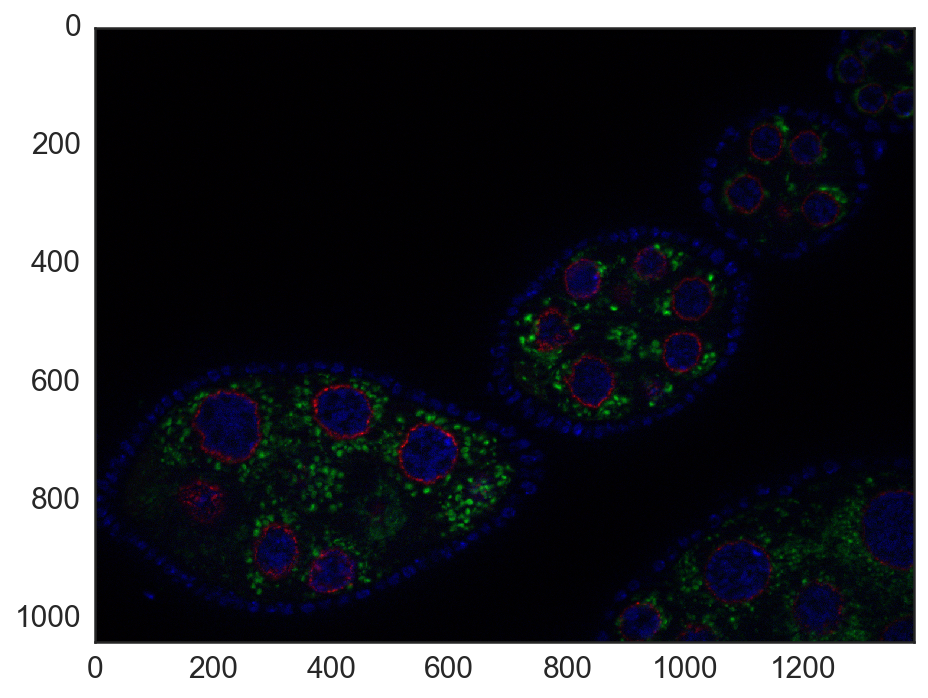

In [34]:
data_dir = '../data/webster_et_al'

# Define file name
fname = os.path.join(data_dir, 'mk2-AubWTxGFP-Zuc_001_40x.TIF')

# Load the image
im = skimage.io.imread(fname)

# Take a look
with sns.axes_style('white'):
    skimage.io.imshow(im)

We need to split out the channels, red being Aubergine, green being Zucchini.

In [35]:
im_r = im[:,:,0]
im_g = im[:,:,1]

Now, we need to define the ROI to use.  This will be where either the Aubergine **or** Zucchini channel has high intensity.

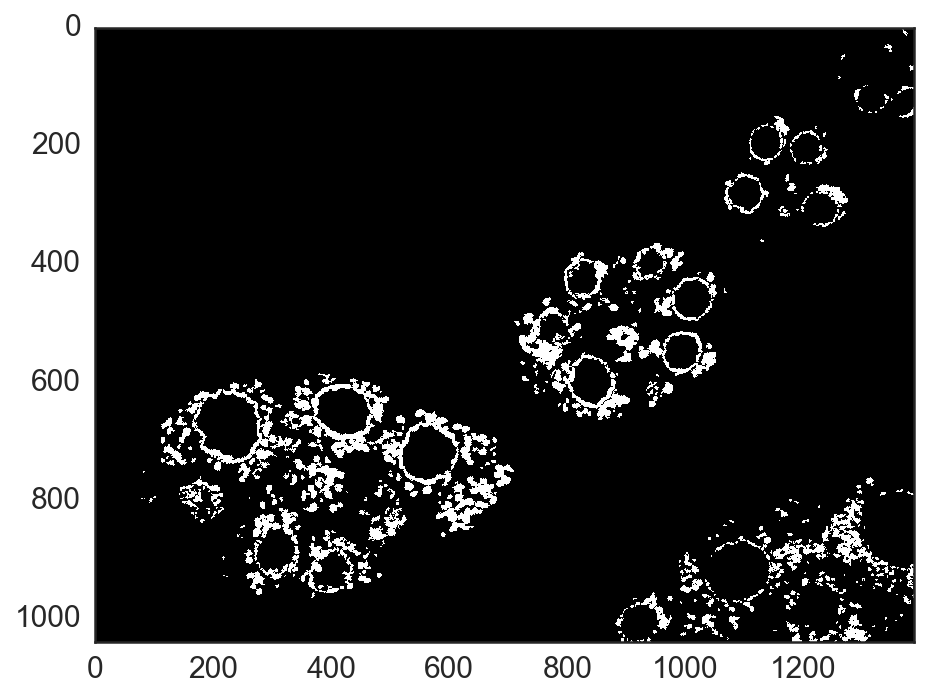

In [39]:
# Determine ROI by global thresholding using Yen's method
thresh_r = skimage.filters.threshold_otsu(im_r)
thresh_g = skimage.filters.threshold_otsu(im_g)

# Make ROI mask
roi = (im_r > thresh_r) | (im_g > thresh_g)
roi = skimage.morphology.remove_small_objects(roi, min_size=9)

# View the ROI
with sns.axes_style('white'):
    plt.imshow(roi, cmap=plt.cm.gray)

We will use Costes's method to perform colocalization.

In [40]:
# Use costes module to perform colocalization
n_scramble = 200
coloc = bebi103.costes_coloc(im_r, im_g, n_scramble=n_scramble, psf_width=3,
                             do_manders=True, roi=roi, roi_method='all')

# Print results
print("""
Pearson r = {0:.2f}
prob of colocalization = {1:.2f}
Manders coefficient for Aubergine = {2:.2f}
Manders coefficient for Zucchini = {3:.2f}
""".format(coloc.pearson_r, coloc.p_coloc, coloc.M_1, coloc.M_2))


Pearson r = -0.59
prob of colocalization = 0.00
Manders coefficient for Aubergine = 0.00
Manders coefficient for Zucchini = 0.00



There is clearly no colocalization between these two.  We'll perform the analysis again with Krimper.

In [42]:
# Define file name
fname = os.path.join(data_dir, 'mk2-AubWTxGFP-Krimp_001_40x.TIF')

# Load the image
im = skimage.io.imread(fname)

# Channels of interest
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

# Compute ROI
thresh_r = skimage.filters.threshold_otsu(im_r)
thresh_g = skimage.filters.threshold_otsu(im_g)
roi = (im_r > thresh_r) | (im_g > thresh_g)
roi = skimage.morphology.remove_small_objects(roi, min_size=9)

# Use costes module to perform colocalization
coloc = bebi103.costes_coloc(im_r, im_g, n_scramble=n_scramble, psf_width=3,
                             do_manders=True, roi=roi, roi_method='all')

# Print results
print("""
Pearson r = {0:.2f}
prob of colocalization = {1:.2f}
Manders coefficient for Aubergine = {2:.2f}
Manders coefficient for Krimper = {3:.2f}
""".format(coloc.pearson_r, coloc.p_coloc, coloc.M_1, coloc.M_2))


Pearson r = 0.70
prob of colocalization = 1.00
Manders coefficient for Aubergine = 0.49
Manders coefficient for Krimper = 0.53



Here, we see colocalization.  Let's get a plot where colocalized pixels are labeled in white.

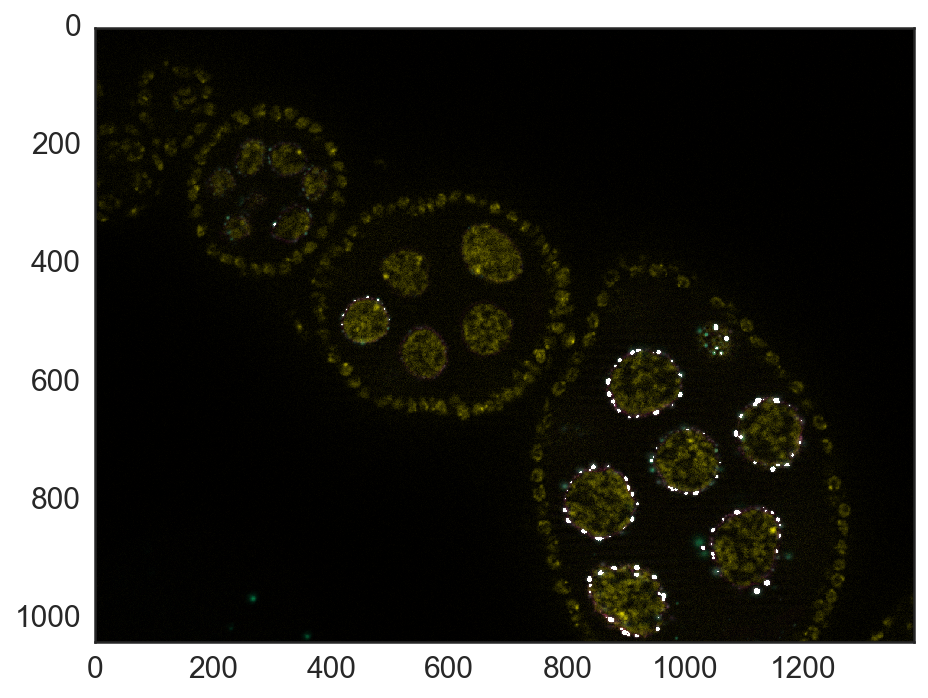

In [43]:
# Make merged image
merged_image = bebi103.im_merge_cmy(im_g, im_r, im_b)

# Inds that will be white
inds = (im_r > coloc.thresh_1) & (im_g > coloc.thresh_2)

# Convert inds to white
merged_image[inds,:] = 1.0

# Show the result
with sns.axes_style('white'):
    plt.imshow(merged_image)

We see punctate colocalization around the nucleus, but not all Krimper granules are colocalized with Aubergine granules.

Let's proceed to look at Tudor.  We use exactly the same techniques.


Pearson r = 0.94
prob of colocalization = 1.00
Manders coefficient for Aubergine = 0.74
Manders coefficient for Krimper = 0.74



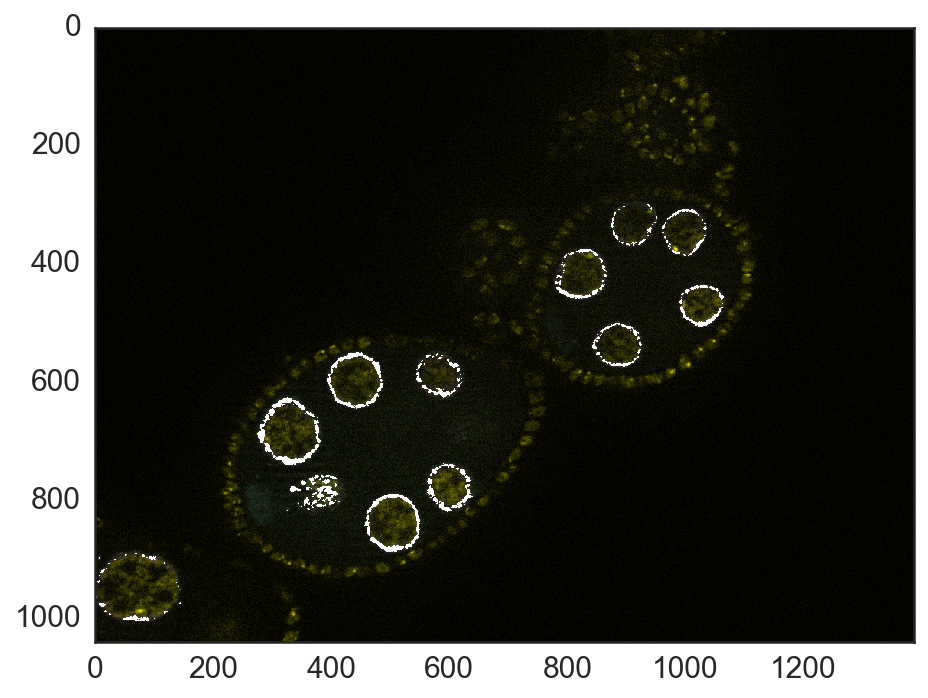

In [46]:
# Define file name
fname = os.path.join(data_dir, 'mk2-AubWTxGFP-Tud_001_40x.TIF')

# Load the image
im = skimage.io.imread(fname)

# Channels of interest
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

# Compute ROI
thresh_r = skimage.filters.threshold_otsu(im_r)
thresh_g = skimage.filters.threshold_otsu(im_g)
roi = (im_r > thresh_r) | (im_g > thresh_g)
roi = skimage.morphology.remove_small_objects(roi, min_size=9)

# Use costes module to perform colocalization
coloc = bebi103.costes_coloc(im_r, im_g, n_scramble=n_scramble, psf_width=3,
                             do_manders=True, roi=roi, roi_method='all')

# Print results
print("""
Pearson r = {0:.2f}
prob of colocalization = {1:.2f}
Manders coefficient for Aubergine = {2:.2f}
Manders coefficient for Krimper = {3:.2f}
""".format(coloc.pearson_r, coloc.p_coloc, coloc.M_1, coloc.M_2))

# Make merged image
merged_image = bebi103.im_merge_cmy(im_g, im_r, im_b)

# Inds that will be white
inds = (im_r > coloc.thresh_1) & (im_g > coloc.thresh_2)

# Convert inds to white
merged_image[inds,:] = 1.0

# Show the result
with sns.axes_style('white'):
    plt.imshow(merged_image)

We see even stronger colocalization with Tudor, having a higher Pearson r and bigger Manders coefficients.  Both are strongly colocalized to the boundary of the nucleus.

<br />
<br />

### Problem 7.3 (Your eyes are not as good as your computer, 5 pts extra credit)

Download the image below.  Use the basic image processing tools we learned in class to replace the beige and magenta colors with white and save the resulting image.  Display the original image and the altered image side by side.  (This problem was inspired by Dan White.)

[<img src="images/swirl.png">](http://bebi103.caltech.edu/2014/data/swirl.png)

### Problem 7.3: solution

To pull out the beige and magenta, we will remove any pixel that has red color.

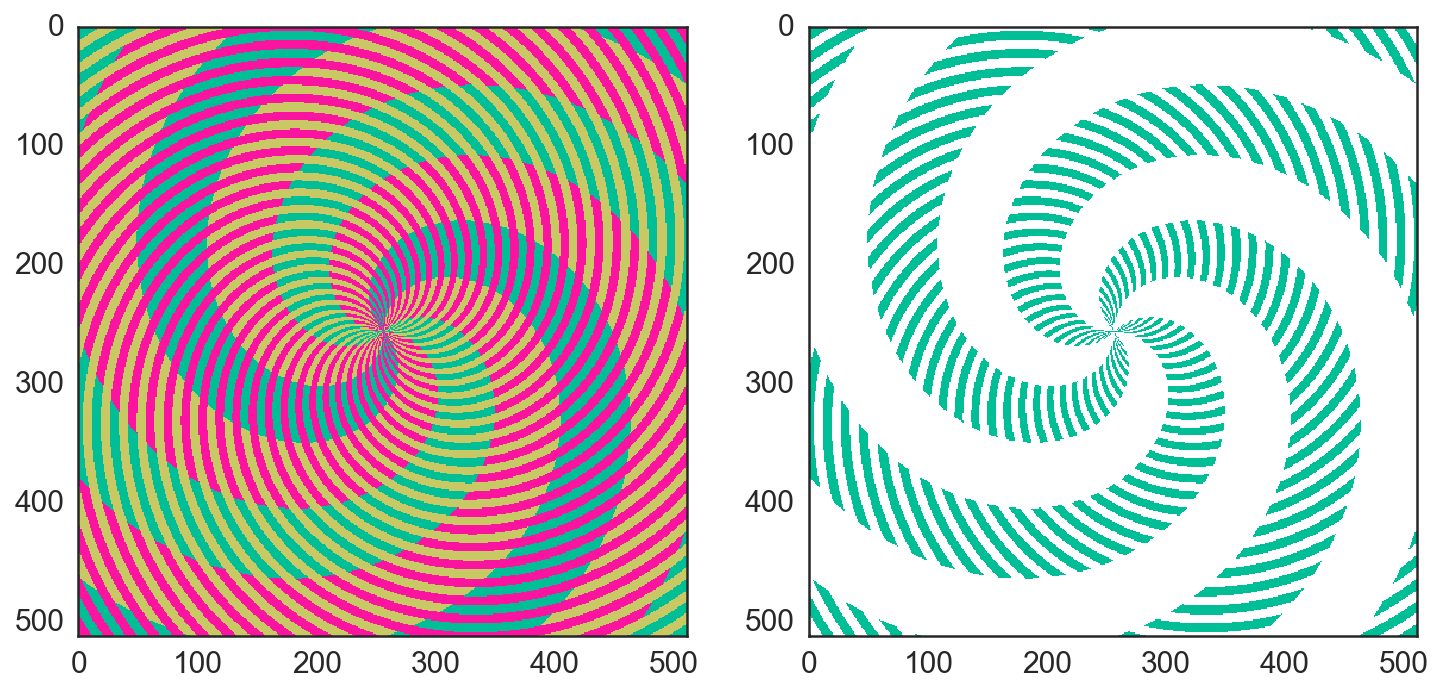

In [47]:
im = skimage.io.imread('../data/swirl.png')

# Strip beige and magenta
im_stripped = im.copy()
im_stripped[im[:,:,0] > 0] = 255

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,8))
    ax[0].imshow(im)
    ax[1].imshow(im_stripped)

Yes, that is right. There are only three colors in the image: beige, magenta, and aqua blue. You computer can "see" this, but your brain gets confused.